In [13]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.runnables import RunnableConfig
from typing import TypedDict, List
from langchain_ollama import ChatOllama
import sqlite3
from IPython.display import Image, display

In [2]:
class State(TypedDict):
    question : str
    messages : List[str]

In [3]:
llm = ChatOllama(model="llama3.2",temperature=0)

In [4]:
def chat_node(state: State):
    prompt = "\n".join(state["messages"]+[state["question"]])
    llm_output = llm.invoke(prompt).content
    return {"messages": state["messages"] + [state["question"] , llm_output] }

In [5]:
conn = sqlite3.connect("checkpoints.sqlite", check_same_thread=False)
memory = SqliteSaver(conn=conn)

In [6]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot" , chat_node)
graph_builder.add_edge(START , "chatbot")
graph_builder.add_edge("chatbot" , END)

graph = graph_builder.compile(checkpointer=memory)

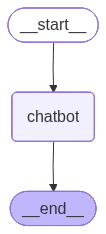

In [14]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config: RunnableConfig = {"configurable": {"thread_id": "user-007"}}
prev_state = memory.get(config=config)
messages = prev_state["channel_values"].get('messages') if prev_state else []
print(f'# -------------------- Previous Chat History --------------------- # \n {messages}')
print(f'# -------------------- Current LLM Response ---------------------- # \n {graph.invoke({"question": "Now tell me in my previous reponse what I have told you to remember", "messages": messages}, config)["messages"][-1]}')

# -------------------- Previous Chat History --------------------- # 
 ['Explain in more detail about country China', "China is a vast and diverse country located in East Asia, with a rich history dating back over 4,000 years. Here's an overview of the country:\n\n**Geography**\n\nChina is the world's third-largest country by land area, covering approximately 9.6 million square kilometers (3.7 million square miles). It borders 14 countries, including India, Nepal, Bhutan, and Mongolia to the west; Russia and North Korea to the north; South Korea and Japan to the east; and Vietnam, Laos, and Myanmar to the south.\n\nChina's terrain is varied, with mountains, plains, deserts, and rivers. The Himalayas, the world's highest mountain range, runs along China's western border. The Yangtze River, the longest river in Asia, flows through the country from west to east. The Great Wall of China, one of the Seven Wonders of the Medieval World, stretches over 13,000 miles (21,000 km) across northern

In [11]:
config: RunnableConfig = {"configurable": {"thread_id": "user-007"}}

while True:
    prev_state = memory.get(config=config)
    messages = prev_state["channel_values"].get('messages') if prev_state else []
    user_question = input()
    if user_question.lower() in {'quit','q','exit'} :
        break
    print(f'# ----------------- Current LLM Response -------------------- #')
    print(graph.invoke({"question": user_question, "messages": messages}, config)["messages"][-1]) # type: ignore

# ----------------- Current LLM Response -------------------- #
Here's a summary of your previous question responses:

1. You asked about the capital of India, and I clarified that New Delhi is indeed the capital, but it doesn't have a "vice capital".
2. You asked about the national anthem of India, and I provided information on its history, composition, inspiration, adoption, meaning, performance, language, and symbolism.
3. You asked about the financial capital of India, and I mentioned that Mumbai (formerly known as Bombay) is often referred to as the financial capital due to its status as a major hub for banking, finance, and commerce.
4. You asked about the National Capital Territory of Delhi, and I provided information on its establishment, territorial boundaries, government structure, administrative functions, economic significance, population density, infrastructure development, and cultural significance.

Let me know if you have any further questions or if there's anything els